In [2]:
"""
Links

    https://blog.csdn.net/weixin_44023658/article/details/105843701 (the author copies pytorch code from somewhere else)

"""
!pip install scikit-learn


In [3]:
from google.colab import drive
import pandas as pd
import torch

torch.manual_seed(42)

pd.set_option("precision", 4)

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print("%d GPU(s) available, namely %s" % (torch.cuda.device_count(), torch.cuda.get_device_name(0)))
else:
    device = torch.device("cpu")
    print('No GPU available, using CPU instead.')

drive.mount("/content/gdrive")


1 GPU(s) available, namely Tesla T4
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
# Split data

import os
from shutil import copy
import random


IMAGE_PATH = "/content/gdrive/My Drive/xheng/data/flower_photos"  # flower dataset's path
split_rate = 0.1


def mkdir(path):
    """ccreate a dir if not existing
    """
    if not os.path.exists(path):
        os.makedirs(path)


flower_classes = [cla for cla in os.listdir(IMAGE_PATH) if ".txt" not in cla]
print("flower_classes has %d elements: %s" % (len(flower_classes), str(flower_classes)))
if 1 == 0:
    mkdir('%s/train' % IMAGE_PATH)
    mkdir('%s/val' % IMAGE_PATH)
    for cla in flower_classes:
        mkdir(IMAGE_PATH + '/train/' + cla)
        mkdir(IMAGE_PATH + '/val/' + cla)

    for cla in flower_classes:
        cla_path = IMAGE_PATH + '/' + cla + '/'
        images = os.listdir(cla_path)
        num = len(images)
        eval_index = random.sample(images, k=int(num*split_rate))
        for index, image in enumerate(images):
            img_file = cla_path + image
            if image in eval_index:
                new_path = IMAGE_PATH + '/val/' + cla
            else:
                new_path = IMAGE_PATH + '/train/' + cla
    
            copy(img_file, new_path)
            print("\r[{}] processing [{}/{}]".format(cla, index+1, num), end="")  # processing bar
        print()
    print("Processing done!")
else:
    print("Choose not to run split data")


flower_classes has 6 elements: ['daisy', 'roses', 'dandelion', 'sunflowers', 'tulips', 'processed_data']
Choose not to run split data


In [7]:
# model.py
import torch.nn as nn
import torch


# 18/34
class BasicBlock(nn.Module):
    expansion = 1  # 每一个conv的卷积核个数的倍数

    def __init__(self, in_channel, out_channel, stride: int = 1, downsample: int = None):
        """
        Args:
            downsample: downsample对应虚线残差结构
        """
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channel, 
            out_channels=out_channel,
            kernel_size=3, 
            stride=stride, 
            padding=1, 
            bias=False
            )
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv2d(
            in_channels=out_channel, 
            out_channels=out_channel,
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False
            )
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x  # 捷径上的输出值
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity  # F(x) + x  
        out = self.relu(out)
        return out


# 50,101,152
class Bottleneck(nn.Module):
    expansion = 4  # 4倍

    def __init__(self, in_channel, out_channel, stride: int = 1, downsample: int = None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(  # squeeze channels
            in_channels=in_channel, 
            out_channels=out_channel,
            kernel_size=1, 
            stride=1, 
            bias=False
            )  
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU(inplace=True)
        
        # -----------------------------------------
        self.conv2 = nn.Conv2d(
            in_channels=out_channel, 
            out_channels=out_channel,
            kernel_size=3, 
            stride=stride, 
            bias=False, 
            padding=1
            )
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU(inplace=True)
        
        # -----------------------------------------
        self.conv3 = nn.Conv2d(  # unsqueeze channels
            in_channels=out_channel, 
            out_channels=out_channel*self.expansion,  # 输出 * 4
            kernel_size=1, 
            stride=1, 
            bias=False
            )
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, blocks_num, num_classes: int = 1000, include_top: bool = True):  
        """
        
        Args:
            block: block残差结构 
            include_top: 为了之后搭建更加复杂的网络
        """
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64
        self.conv1 = nn.Conv2d(
            3, self.in_channel, kernel_size=7, stride=2, padding=3, bias=False
            )
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        assert len(blocks_num) == 4
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)自适应
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion)
                )
        layers = []
        layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride))
        self.in_channel = channel * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channel, channel))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)
        return x


def resnet34(num_classes: int = 1000, include_top: bool = True):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet101(num_classes: int = 1000, include_top: bool = True):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top)


In [8]:
# train.py

import json
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
import torchvision.models.resnet

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),  # 来自官网参数
    "val": transforms.Compose([transforms.Resize(256),  # 将最小边长缩放到256
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

train_dataset = datasets.ImageFolder(
    root=IMAGE_PATH + "/processed_data/train", transform=data_transform["train"]
    )
train_num = len(train_dataset)

# {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
flower_list = train_dataset.class_to_idx
cla_dict = dict((val, key) for key, val in flower_list.items())

# Write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open(IMAGE_PATH + '/processed_data/class_indices.json', 'w') as json_file:
    json_file.write(json_str)

batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

validate_dataset = datasets.ImageFolder(
    root=IMAGE_PATH + "/processed_data/val", transform=data_transform["val"]
    )
val_num = len(validate_dataset)
validate_loader = torch.utils.data.DataLoader(validate_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

net = resnet34(num_classes=5)

# load pretrain weights
# model_weight_path = "./resnet34-pre.pth"
# missing_keys, unexpected_keys = net.load_state_dict(torch.load(model_weight_path), strict=False)#载入模型参数
# for param in net.parameters():
#     param.requires_grad = False
# change fc layer structure
# inchannel = net.fc.in_features
# net.fc = nn.Linear(inchannel, 5)

net.to(device)

########################
# Start the training
########################

num_epochs = 4
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
save_path = IMAGE_PATH + "/processed_data/resnet34.pth"

# 
best_acc = 0.0
for epoch in range(num_epochs):
    # train
    net.train()
    running_loss = 0.0
    for step, data in enumerate(train_loader, start=0):
        images, labels = data
        optimizer.zero_grad()
        logits = net(images.to(device))
        loss = loss_function(logits, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print train process
        rate = (step+1)/len(train_loader)
        a = "*" * int(rate * 50)
        b = "." * int((1 - rate) * 50)
        print("\rtrain loss: {:^3.0f}%[{}->{}]{:.4f}".format(int(rate*100), a, b, loss), end="")
    print()

    # validate
    net.eval()
    acc = 0.0  # accumulate accurate number / epoch
    with torch.no_grad():
        for val_data in validate_loader:
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))  # eval model only have last output layer
            # loss = loss_function(outputs, test_labels)
            predict_y = torch.max(outputs, dim=1)[1]
            acc += (predict_y == val_labels.to(device)).sum().item()
        val_acc = acc / val_num
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(net.state_dict(), save_path)
            print("Better model found. Saved at %s" % save_path)

        print("\n[epoch %d] train_loss: %.4f  test_acc: %.4f" %(epoch, running_loss / step, val_acc))

print("Finished Training")


train loss: 100%[**************************************************->]1.1649
Better model found. Saved at /content/gdrive/My Drive/xheng/data/flower_photos/processed_data/resnet34.pth

[epoch 0] train_loss: 1.2997  test_acc: 0.5962
train loss: 100%[**************************************************->]0.8977
Better model found. Saved at /content/gdrive/My Drive/xheng/data/flower_photos/processed_data/resnet34.pth

[epoch 1] train_loss: 1.1149  test_acc: 0.6538
train loss: 100%[**************************************************->]1.3440
Better model found. Saved at /content/gdrive/My Drive/xheng/data/flower_photos/processed_data/resnet34.pth

[epoch 2] train_loss: 0.9963  test_acc: 0.6951
train loss: 100%[**************************************************->]1.1589

[epoch 3] train_loss: 0.9619  test_acc: 0.6593
Finished Training


sunflowers 0.75204366


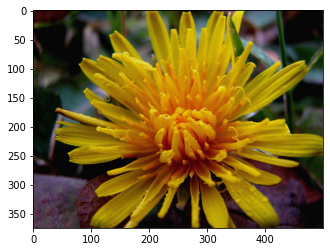

In [18]:
# predict.py

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import json

# load an example image
# roses, dandelion
img = Image.open(IMAGE_PATH + "/processed_data/examples/dandelion.jpg")
plt.imshow(img)

##########################
# Make a prediction
##########################
data_transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
     ])

# [N, C, H, W]
img = data_transform(img)
img = torch.unsqueeze(img, dim=0) # expand batch dimension

json_file = open(IMAGE_PATH + '/processed_data/class_indices.json', 'r')  # read class_indict 
class_indict = json.load(json_file)

model = resnet34(num_classes=5)  # create model
model_weight_path = IMAGE_PATH + "/processed_data/resnet34.pth"  # load model weights
model.load_state_dict(torch.load(model_weight_path))
model.eval()
with torch.no_grad():
    output = torch.squeeze(model(img))
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()
print(class_indict[str(predict_cla)], predict[predict_cla].numpy())
plt.show()